# Import needed libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from matplotlib import gridspec
from matplotlib.collections import LineCollection

#Import functions from developed library
from big_slam import lead_lag_detector,load_test_data,recurrence_plot,max_peak_detector,wave_slam_detector


# Data collection

In [2]:
df_1 = load_test_data(2,2) # Collect data from the test for region 2
#Symmetric ordering of accelerometers
acc_arrangment = [0,2,4,6,8,9,7,5,3,1]
df_1.head()

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Channel_9,Channel_10
0,0.012914,0.009178,0.024539,-0.024094,-0.021595,0.035342,-0.011631,0.029073,0.014948,0.039330
1,0.014088,0.010685,0.023546,-0.028489,-0.021163,0.031303,-0.010780,0.024760,0.015238,0.039623
2,0.015262,0.010411,0.021985,-0.027428,-0.019292,0.031303,-0.010638,0.019753,0.014077,0.040063
3,0.011447,0.009726,0.022269,-0.026064,-0.020443,0.031736,-0.010922,0.017110,0.013642,0.041824
4,0.009832,0.008493,0.024397,-0.027580,-0.018284,0.033467,-0.010071,0.017527,0.013497,0.042558


## PSD - Figure 4.4
### for all accelerometers used across all region tests

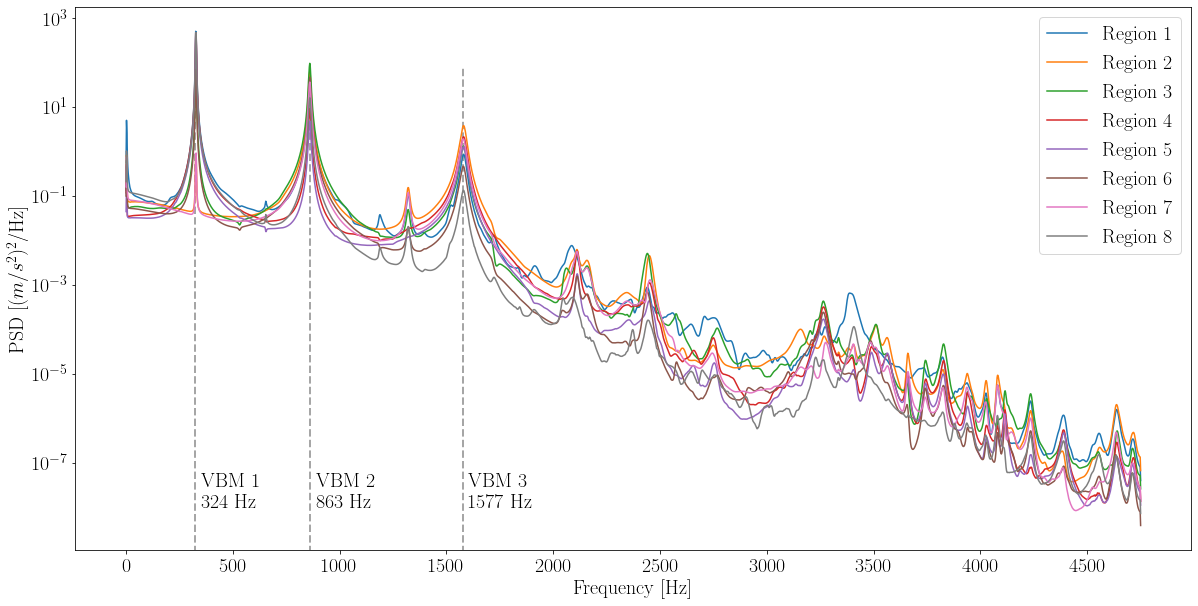

In [3]:
#Set plot parameters
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = "serif"


#Sampling frequency
fs = 9500 

cap =2 
psd_region = []

for region in range(1,9):

    #load data for specific cap and region
    data = load_test_data(region,cap)

    #Drop Channel_2 data for Cap 3 PSD
    if (cap ==3):
        data.drop(columns=['Channel_2'],inplace = True)

    psd_acc = []
    #Calculate PSD for each accelerometer
    for acc in range(data.shape[1]):

        f, Pxx_acc = signal.welch(data.iloc[:,acc].values, fs, nperseg=4750)
        psd_acc.append(Pxx_acc)

    psd_acc_mean = np.array(psd_acc).mean(axis=0)
    psd_region.append(psd_acc_mean)
    
plt.figure(figsize=(20,10))

for i in np.arange(0,8):
    plt.semilogy(f,psd_region[i],label = 'Region %d'%(i+1))

plt.xlabel('Frequency [Hz]');
plt.ylabel(r'PSD [$(m/s^2) ^2$/Hz]');
plt.xticks([0,500,1000,1500,2000,2500,3000,3500,4000,4500])
plt.vlines([324,862,1577], 0, 80,'grey',linestyles = 'dashed',linewidths=2,alpha=0.7)

plt.annotate('VBM 1 \n  324 Hz' ,xy = (344+5,10e-9))

plt.annotate('VBM 2 \n  863 Hz' ,xy = (883+5,10e-9))


plt.annotate('VBM 3 \n  1577 Hz' , xy = (1598+5,10e-9))


plt.legend()
    

# Pre-processing
## Example impulse in region 2 - Figure 4.3

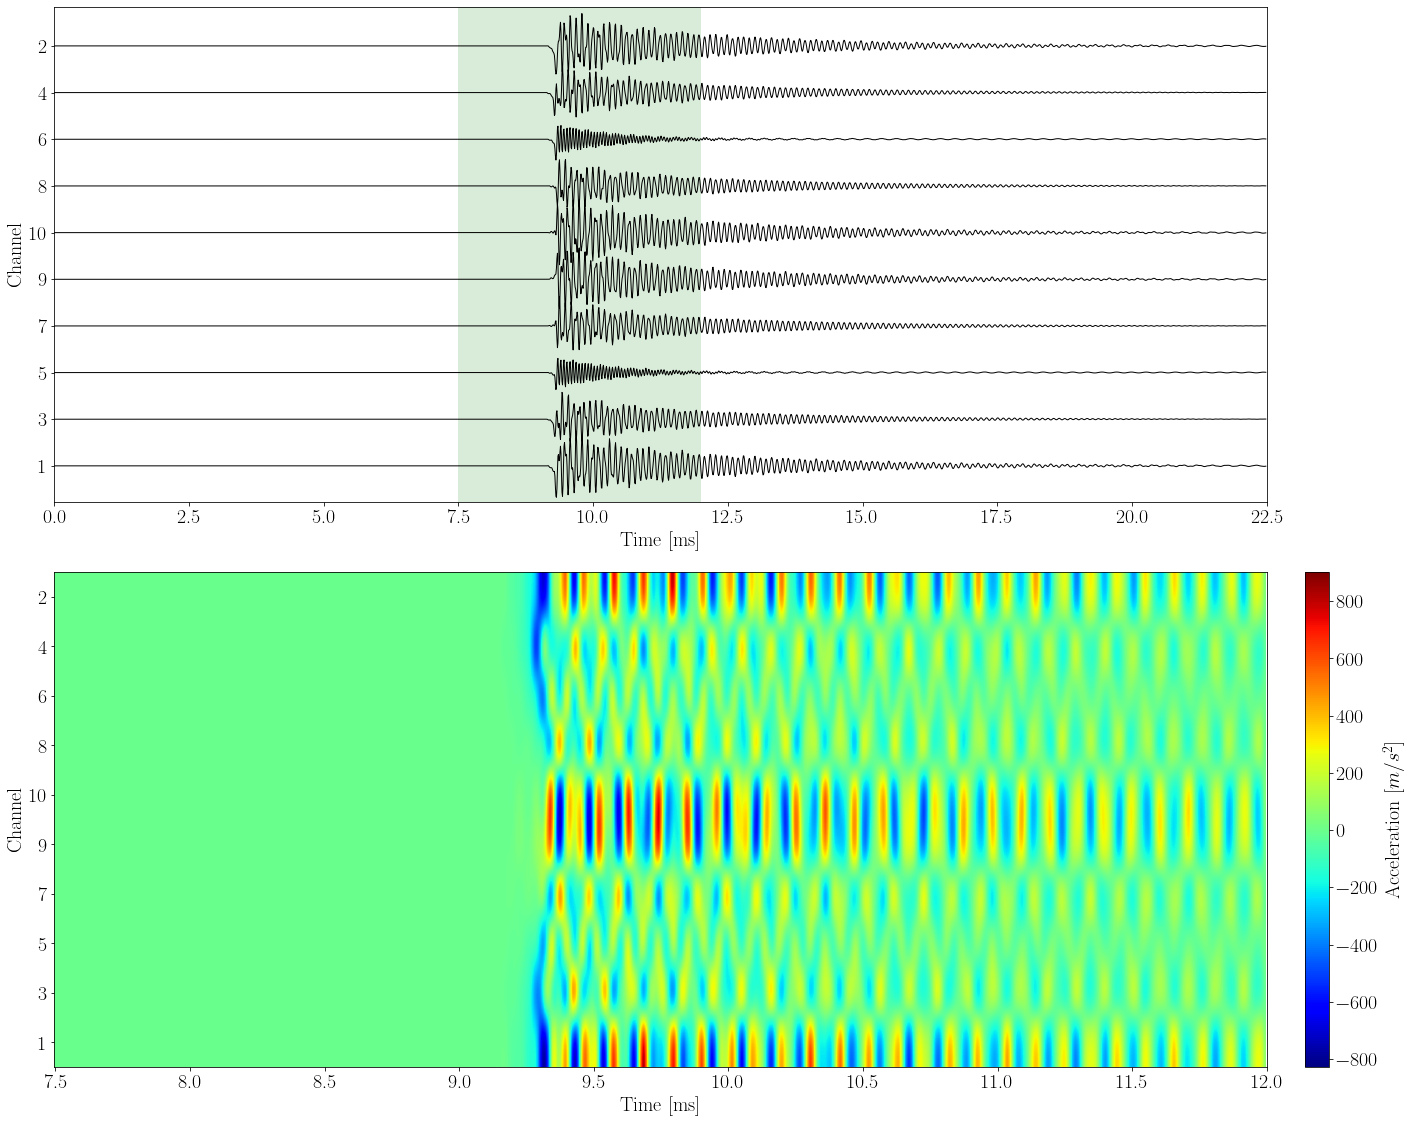

In [8]:

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = "serif"


fig = plt.figure(figsize=(20,16))
gs = gridspec.GridSpec(2, 2, height_ratios=(20, 20), width_ratios=(50, 1))

# first graph
axes = plt.subplot(gs[0,0])

n_rows = 10
data = df_1.iloc[25500:28000-100,acc_arrangment].values
t = range(data.shape[0])
ticklocs = []

axes.set_xlim(0, data.shape[0])

dmin = data.min()
dmax = data.max()
dr = 1200#
y0 = dmin -100
y1 = (n_rows - 1) * dr + dmax +100
axes.set_ylim(y0, y1)

segs = []
for i in range(n_rows):
    segs.append(np.column_stack((t, data[:, i])))
    ticklocs.append(i * dr)

offsets = np.zeros((n_rows, 2), dtype=float)
offsets[:, 1] = ticklocs

lines = LineCollection(segs, offsets=offsets,colors='black',linewidths=1)
axes.add_collection(lines)
axes.set_yticks(np.linspace(0,10,10)*1080)
axes.set_xlabel('Time [ms]')
axes.set_ylabel('Channel')
axes.set_yticklabels(np.array(acc_arrangment)+1);

axes.set_xticks(np.linspace(0,2400,10))
axes.set_xticklabels(np.arange(0,25,2.5))


axes.fill_between((800,750+530),y0, y1, facecolor='green', alpha=0.15)

# second graph
axes = plt.subplot(gs[1,0])
data = df_1.iloc[25500+800:25500+750+530,acc_arrangment].values


im = axes.imshow(data.T,aspect='auto',cmap='jet',origin='lower',interpolation='gaussian')

axes.set_yticks(np.linspace(0,9,10))
axes.set_yticklabels(np.array(acc_arrangment)+1);

axes.set_xticks(np.linspace(0,data.shape[0],10))
axes.set_xticklabels(np.linspace(7.5,12,10))

axes.set_xlabel('Time [ms]')
axes.set_ylabel('Channel')
#fig.colorbar(im)


# colorbar
axes = plt.subplot(gs[1,1])
cb =plt.colorbar(im, cax=axes)
cb.set_label(r'Acceleration [$m/s^2$]')

plt.tight_layout()

#plt.savefig('Experiment_periodogram_all_regions.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

## Spectrogram - Figure 4.5

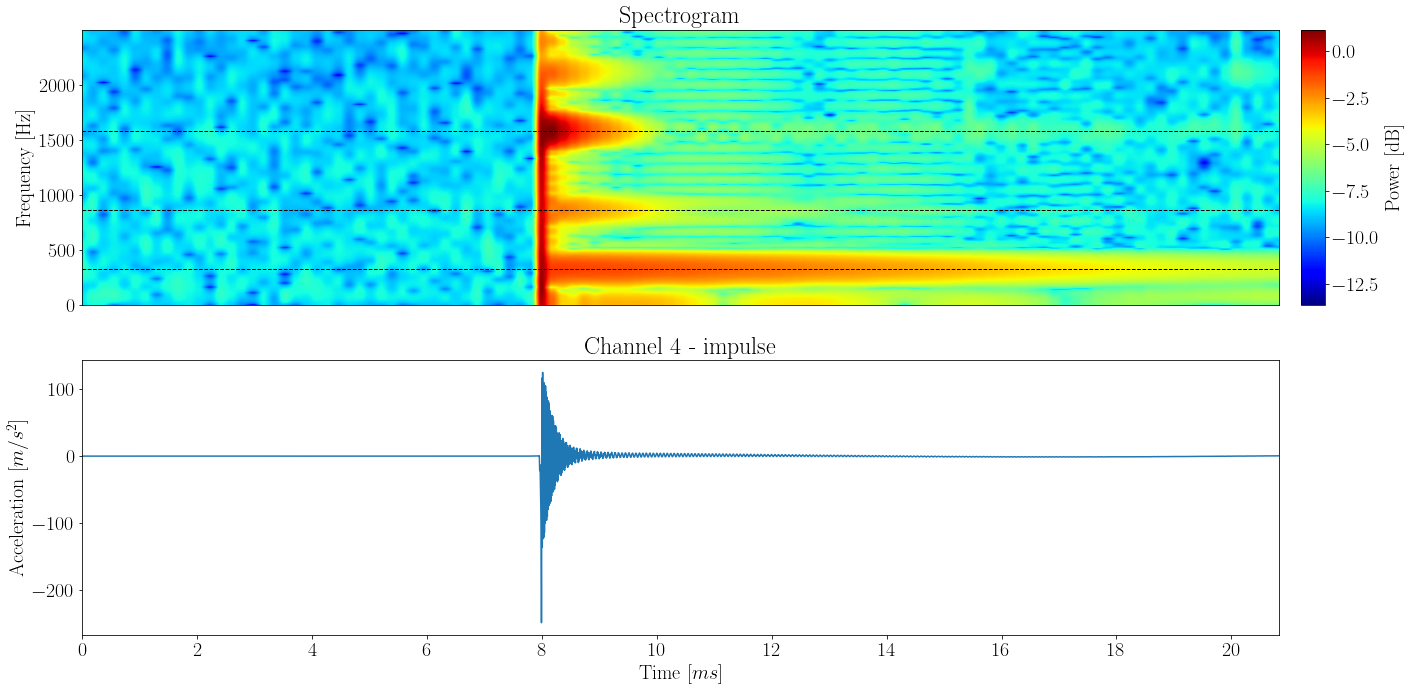

In [9]:
x = df_1.iloc[10000:20000,4].values 
freqs, times, spectrogram = signal.spectrogram(x,fs=9500,nfft=9500,nperseg=100,window=('hamming'))


fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(2, 2, height_ratios=(20, 20), width_ratios=(50, 1))
# first graph
axes = plt.subplot(gs[0,0])

im = axes.imshow(np.log10(spectrogram[0:2500]), aspect='auto', cmap='jet', origin='lower')
axes.set_title('Spectrogram')
axes.set_ylabel(r'Frequency [Hz]')
axes.xaxis.set_visible(False)
axes.hlines([324,862,1577], 0, 113,'k',linestyles = 'dashed',linewidths=1)
axes.set_xlim(0,112)
#axes.annotate('VBM 1' ,xy = (1,324+30),weight='bold',fontsize=25)
#axes.annotate('VBM 2' ,xy = (1,862+30),weight='bold',fontsize=25)
#axes.annotate('VBM 3' , xy =(1,1577+30),weight='bold',fontsize=25)


# Second graph
axes = plt.subplot(gs[1,0])
axes.plot(x)
axes.set_xlim(0,10000)
axes.set_title('Channel 4 - impulse')
axes.set_ylabel(r'Acceleration [$m/s^2$]')
axes.set_xlabel(r'Time [$ms$]')
axes.set_xticks(np.arange(0,10000,960))
axes.set_xticklabels(np.array(np.arange(0,10000,960)/(0.5*960)).astype('int'))


# colorbar
axes = plt.subplot(gs[0,1])
cb =plt.colorbar(im, cax=axes)
cb.set_label(r'Power [dB]')

plt.tight_layout()

#plt.savefig('Spectrogram_example_ch4.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

It is seen that the main impulse response is captured by VBM 3 and lasts from 8 to 10 ms, corresponding to roughly 50 samples

## Sliding time window 
Size   = 100 samples;
Stride = 50 samples

In [12]:
from pyts import utils

index = utils.windowed_view(np.arange(0,df_1.shape[0]).reshape(1, -1),200,100)[0]

## Example RPs - Figure 4.6

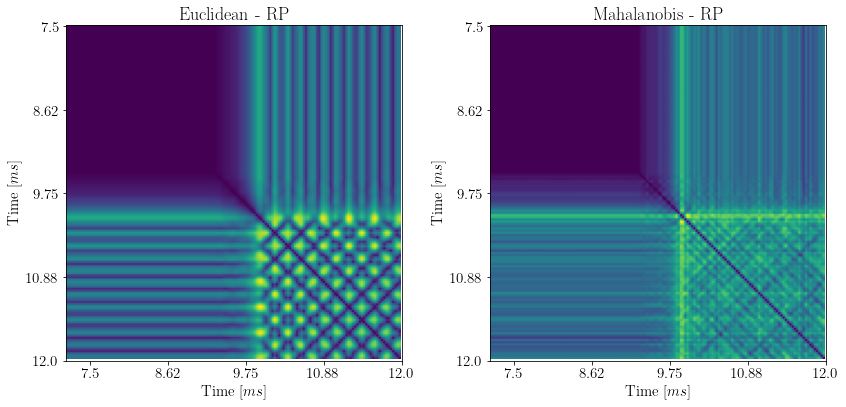

In [11]:
fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(1, 2)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 15
plt.rcParams['font.family'] = "serif"


data = df_1.iloc[13750:13900,acc_arrangment]
method_str = ['euclidean','mahalanobis']
title_str = ['Euclidean - RP','Mahalanobis - RP']

for i,string in enumerate(method_str):
    axes = plt.subplot(gs[0,i])
    d = recurrence_plot(data,string)
    im = axes.imshow(d,cmap='viridis')
    axes.set_xticks(np.linspace(10,data.shape[0],5))
    axes.set_xticklabels(np.linspace(7.5,12,5).round(2),rotation=0)
    axes.set_yticks(np.linspace(0,data.shape[0],5))
    axes.set_yticklabels(np.linspace(7.5,12,5).round(2))
    axes.set_ylabel(r'Time [$ms$]')
    axes.set_xlabel(r'Time [$ms$]')
    axes.set_title(title_str[i])
    
plt.tight_layout()
#plt.savefig('Experiment_example_rps.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

# Feature extraction

In [4]:
%%time
#Parameters
window_size = 200
stride = 100
compressed_window_size = 100
recurrence_plot_type_1 = 'euclidean'
recurrence_plot_type_2 = 'mahalanobis'


#create class
wave_slam_class_euc = wave_slam_detector(df_1)
wave_slam_class_maha = wave_slam_detector(df_1)

wave_slam_class_euc.feature_extraction(window_size,stride,compressed_window_size,recurrence_plot_type_1)
wave_slam_class_maha.feature_extraction(window_size,stride,compressed_window_size,recurrence_plot_type_2)


CPU times: user 27min 29s, sys: 33.6 s, total: 28min 3s
Wall time: 12min 6s


# Dimensionality reduction

## Principle Component Analysis - PCA
## Figure 4.7

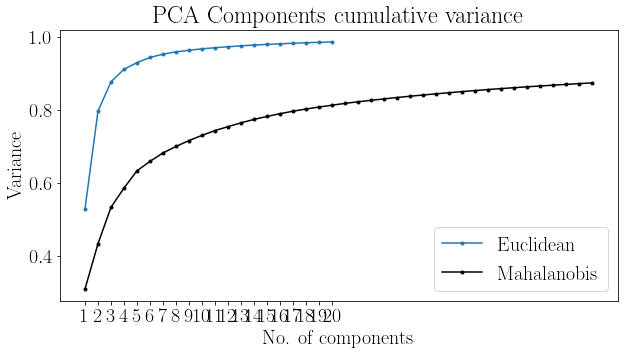

In [6]:

wave_slam_class_euc.PCA(max_components = 20)
wave_slam_class_maha.PCA(max_components = 40)

#PCA transformation per image type
pca_euc = wave_slam_class_euc.pca_model
pca_maha = wave_slam_class_maha.pca_model


fig,ax = plt.subplots(figsize=(10,5))
plt.plot(np.cumsum(pca_euc.explained_variance_ratio_),marker='.',label = 'Euclidean')
plt.plot(np.cumsum(pca_maha.explained_variance_ratio_),marker='.',label = 'Mahalanobis',c='k')
plt.xticks(range(20))
ax.set_xticklabels(np.arange(20)+1)
plt.title('PCA Components cumulative variance');
plt.xlabel('No. of components');
plt.ylabel('Variance');
plt.legend()

#plt.savefig('Cum_PCA_variance.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

## UMAP - Uniform manifold approximation and projection

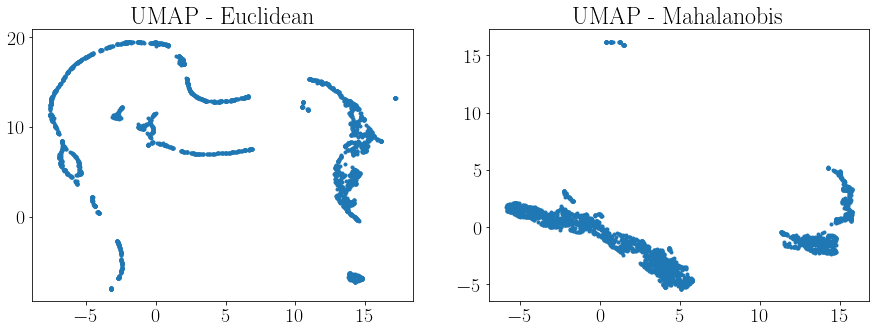

In [7]:

wave_slam_class_euc.UMAP(n_neighbors=10,min_dist=0,plot=False)
wave_slam_class_maha.UMAP(n_neighbors=10,min_dist=0,plot=False)


umap_trans_euc = wave_slam_class_euc.umap_transformed
umap_trans_maha = wave_slam_class_maha.umap_transformed


fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter(umap_trans_euc[:,0],umap_trans_euc[:,1],marker='.')
ax[0].set_title('UMAP - Euclidean');
ax[1].scatter(umap_trans_maha[:,0],umap_trans_maha[:,1],marker='.')
ax[1].set_title('UMAP - Mahalanobis');

### Label the time windows with the known impulse times

In [13]:
pulse_times_df = pd.read_csv('Experiment_Data/Experiment_pulse_times_Cap_2.csv',index_col=0,sep=';')
true_labels_region_2 = np.zeros(len(index))

for pulse in pulse_times_df['region_2_times'].values:
    
    for i,window in enumerate(index):
        if pulse in window[0:50]:
            true_labels_region_2[i] = 1


### Figure 4.8

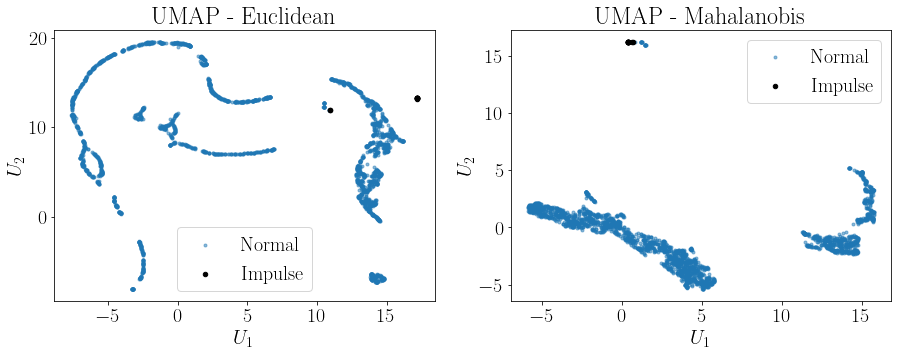

In [14]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter(umap_trans_euc[true_labels_region_2==0,0],umap_trans_euc[true_labels_region_2==0,1],alpha=0.5,label='Normal',marker='.')
ax[0].scatter(umap_trans_euc[true_labels_region_2==1,0],umap_trans_euc[true_labels_region_2==1,1],alpha=1,c='k',label='Impulse',s=20,marker='o')
ax[0].set_xlabel(r'$U_1$')
ax[0].set_ylabel(r'$U_2$')
ax[0].set_title('UMAP - Euclidean');
ax[0].legend()

ax[1].scatter(umap_trans_maha[true_labels_region_2==0,0],umap_trans_maha[true_labels_region_2==0,1],alpha=0.5,label='Normal',marker='.')
ax[1].scatter(umap_trans_maha[true_labels_region_2==1,0],umap_trans_maha[true_labels_region_2==1,1],alpha=1,c='k',label='Impulse',s=20,marker='o')
ax[1].set_xlabel(r'$U_1$')
ax[1].set_ylabel(r'$U_2$')
ax[1].set_title('UMAP - Mahalanobis');
ax[1].legend()

#plt.savefig('UMAP_true_labels.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)


# Clustering
### Figure 4.9

Text(0.5, 1.0, 'UMAP decomposition - Euclidean')

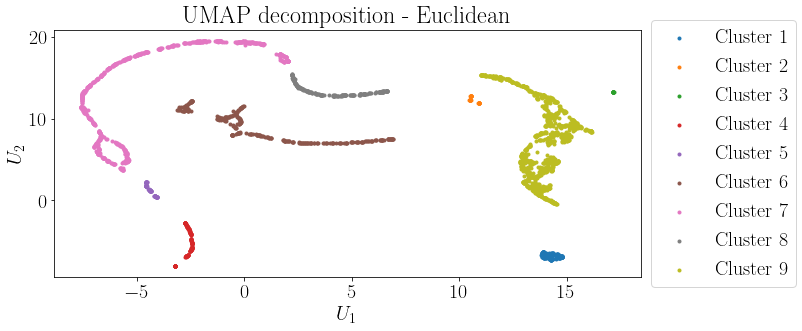

In [15]:
wave_slam_class_euc.clustering(eps=1.5,min_samples=5,plot=True)
plt.title('UMAP decomposition - Euclidean');
#plt.savefig('UMAP_cluster_labels_euclidean.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

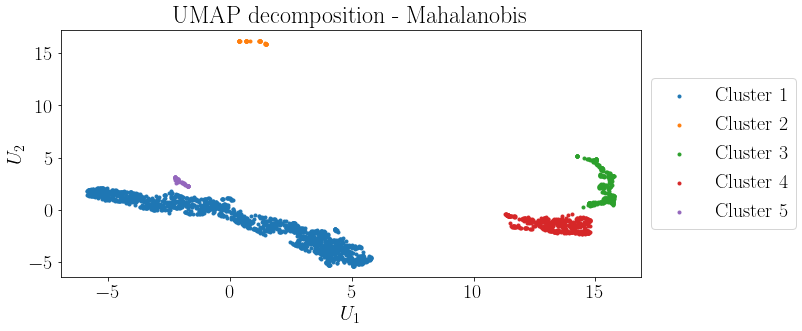

In [22]:
wave_slam_class_maha.clustering(eps=.5,min_samples=5,plot=True)
plt.title('UMAP decomposition - Mahalanobis');
#plt.savefig('UMAP_cluster_labels_mahalanobis.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

## Map cluster labels to time domain
## Figure 4.10

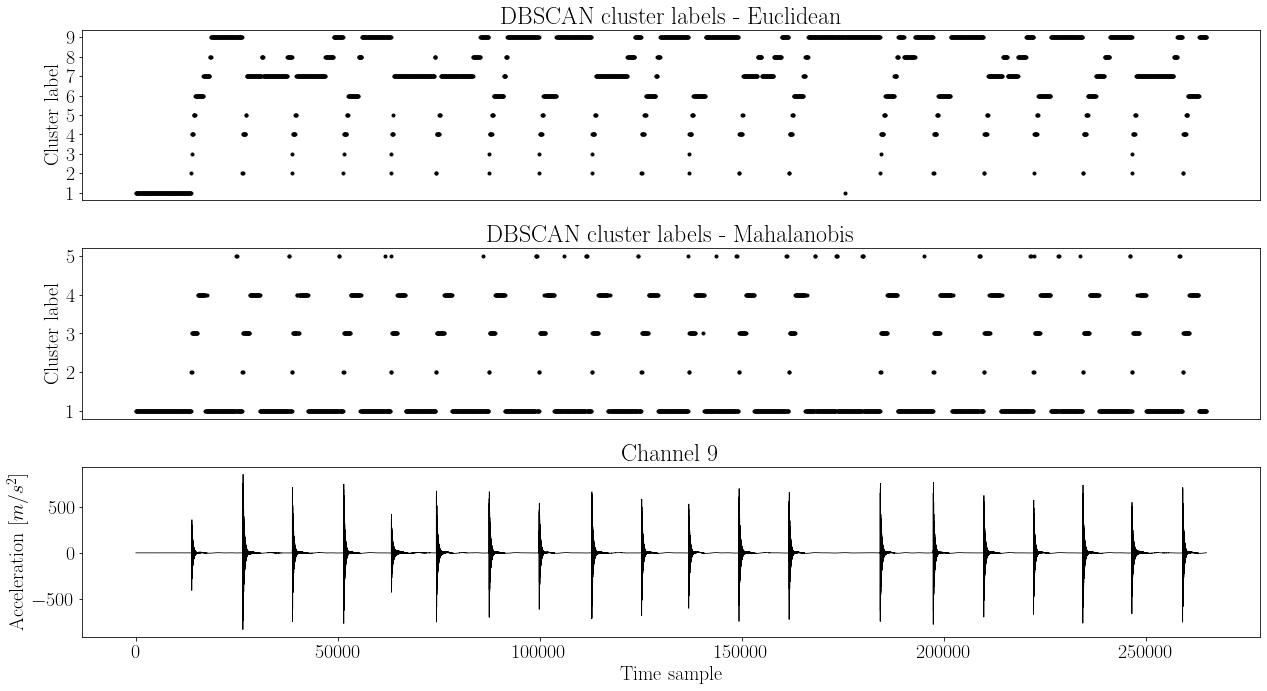

In [23]:

fig,ax = plt.subplots(3,1,figsize=(18,10))

ax[0].plot(wave_slam_class_euc.DBSCAN_feature_labels,'k.')
ax[0].set_ylabel('Cluster label')
ax[0].set_yticks(np.arange(1,wave_slam_class_euc.DBSCAN_feature_labels.max()+1))
ax[0].xaxis.set_visible(False)
ax[0].set_title('DBSCAN cluster labels - Euclidean');

ax[1].plot(wave_slam_class_maha.DBSCAN_feature_labels,'k.')
ax[1].set_ylabel('Cluster label')
ax[1].set_yticks(np.arange(1,wave_slam_class_maha.DBSCAN_feature_labels.max()+1))
ax[1].xaxis.set_visible(False)
ax[1].set_title('DBSCAN cluster labels - Mahalanobis');


ax[2].plot(df_1.iloc[:,9].values,'k',linewidth=0.8)
ax[2].set_title('Channel 9');
#ax[1].set_xticks(np.arange(0,33600,2400))
#ax[1].set_xticklabels(np.arange(0,33600,2400)/9600)
ax[2].set_ylabel(r'Acceleration [$m/s^2$]')
ax[2].set_xlabel(r'Time sample');

plt.tight_layout()

#plt.savefig('Cluster_labels_in_time.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

Mahalanobis clusters are simpler and map well to the signal characteristics. Cluster two is used to group the found labels in time and detect the impact.

# Classification
## Identify cluster corresponding to wave slamming

In [55]:
wave_slam_class_maha.chosen_cluster = 2

## Impact number and the approximate time of impact is given as:

In [57]:
# cluster in time using eps of 2 sample points
wave_slam_class_maha.clustering_in_time(eps=2)

/Users/torick/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,impact_number,start_time_sample,end_time_sample,approximate_impact_time_sample
0,1,13750,13899,13843
1,2,26400,26549,26500
2,3,38650,38799,38752
3,4,51350,51499,51464
4,5,63150,63299,63238
5,6,74300,74449,74388
6,7,87350,87499,87459
7,8,99750,99899,99844
8,9,112750,112899,112851
9,10,125100,125249,125194


# Location detection

## Concept 1

In [58]:
# Region of accuracy for each region hit sequence
local_specificity = [[1,2],[3,4],[3,4],[5,6],[5,6],[7,8],[7,8],[9,10]]
regional_specificity = [[1,2,3,4],[1,2,3,4],[3,4,5,6],[3,4,5,6],[5,6,7,8],[5,6,7,8],[7,8,9,10],[7,8,9,10]]

#List of accuracy grids per region for local/regional accuracy
w_gauss_opt_1_list = []
w_gauss_opt_2_list = []

#Parameters
window_sizes = np.arange(50,300,25)
gaussian_std = np.arange(0,5,0.5)

for r in np.arange(1,9):
    region = r
    df = load_test_data(region,2)
    num_sensors = df.shape[1]
    w_gauss_opt_1 = np.zeros((10,10))
    w_gauss_opt_2 = np.zeros((10,10))

    for window_index,window_param in enumerate(window_sizes):
        for gauss_index,gauss_param in enumerate(gaussian_std):
            sensor_hits = []
            
            #Loop through the labeled pulse times 
            for i in range(20):
        
                impact_time = pulse_times_df.iloc[i,region-1]
            
                data_window_range = [impact_time-window_param,impact_time+window_param]
            
                #Extract the surrounding time window and apply preprocessing
                
                data_window = df[data_window_range[0]:data_window_range[1]]
                
                #Instantiate the lead_lag_detector
                lead_lag = lead_lag_detector(data_window,num_sensors,gauss_param)

                sensor_hits.append(lead_lag.pulse_location+1)
                
            accuracy_1 = np.array([i in local_specificity[region-1] for i in sensor_hits]).mean()
            accuracy_2 = np.array([i in regional_specificity[region-1] for i in sensor_hits]).mean()

            w_gauss_opt_1[window_index,gauss_index] = accuracy_1
            w_gauss_opt_2[window_index,gauss_index] = accuracy_2
            
    w_gauss_opt_1_list.append(w_gauss_opt_1)
    w_gauss_opt_2_list.append(w_gauss_opt_2)

### Region 2 results - Figure 4.11

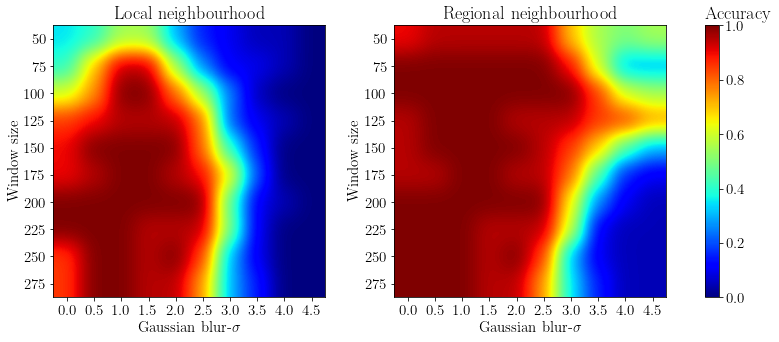

In [77]:
fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].imshow(w_gauss_opt_1_list[1],aspect='equal',cmap='jet',interpolation='gaussian',vmin=0,vmax=1)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_yticklabels(window_sizes)
ax[0].set_xticklabels(gaussian_std)
ax[0].set_xlabel(r'Gaussian blur-$\sigma$')
ax[0].set_ylabel('Window size')
ax[0].set_title('Local neighbourhood')
#ax[i,0].set_colorbar()

im = ax[1].imshow(w_gauss_opt_2_list[1],aspect='equal',cmap='jet',interpolation='gaussian',vmin=0,vmax=1)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_yticklabels(window_sizes)
ax[1].set_xticklabels(gaussian_std)
ax[1].set_xlabel(r'Gaussian blur-$\sigma$')
ax[1].set_ylabel('Window size')
ax[1].set_title('Regional neighbourhood')

import matplotlib
cmap_str = 'jet'
clb = plt.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap_str), ax=ax)
clb.ax.set_title('Accuracy',loc='left');

#plt.savefig('Region_2_local_regional_gridsearch.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

## All Regions - location detection grid search
## Appendix C.3

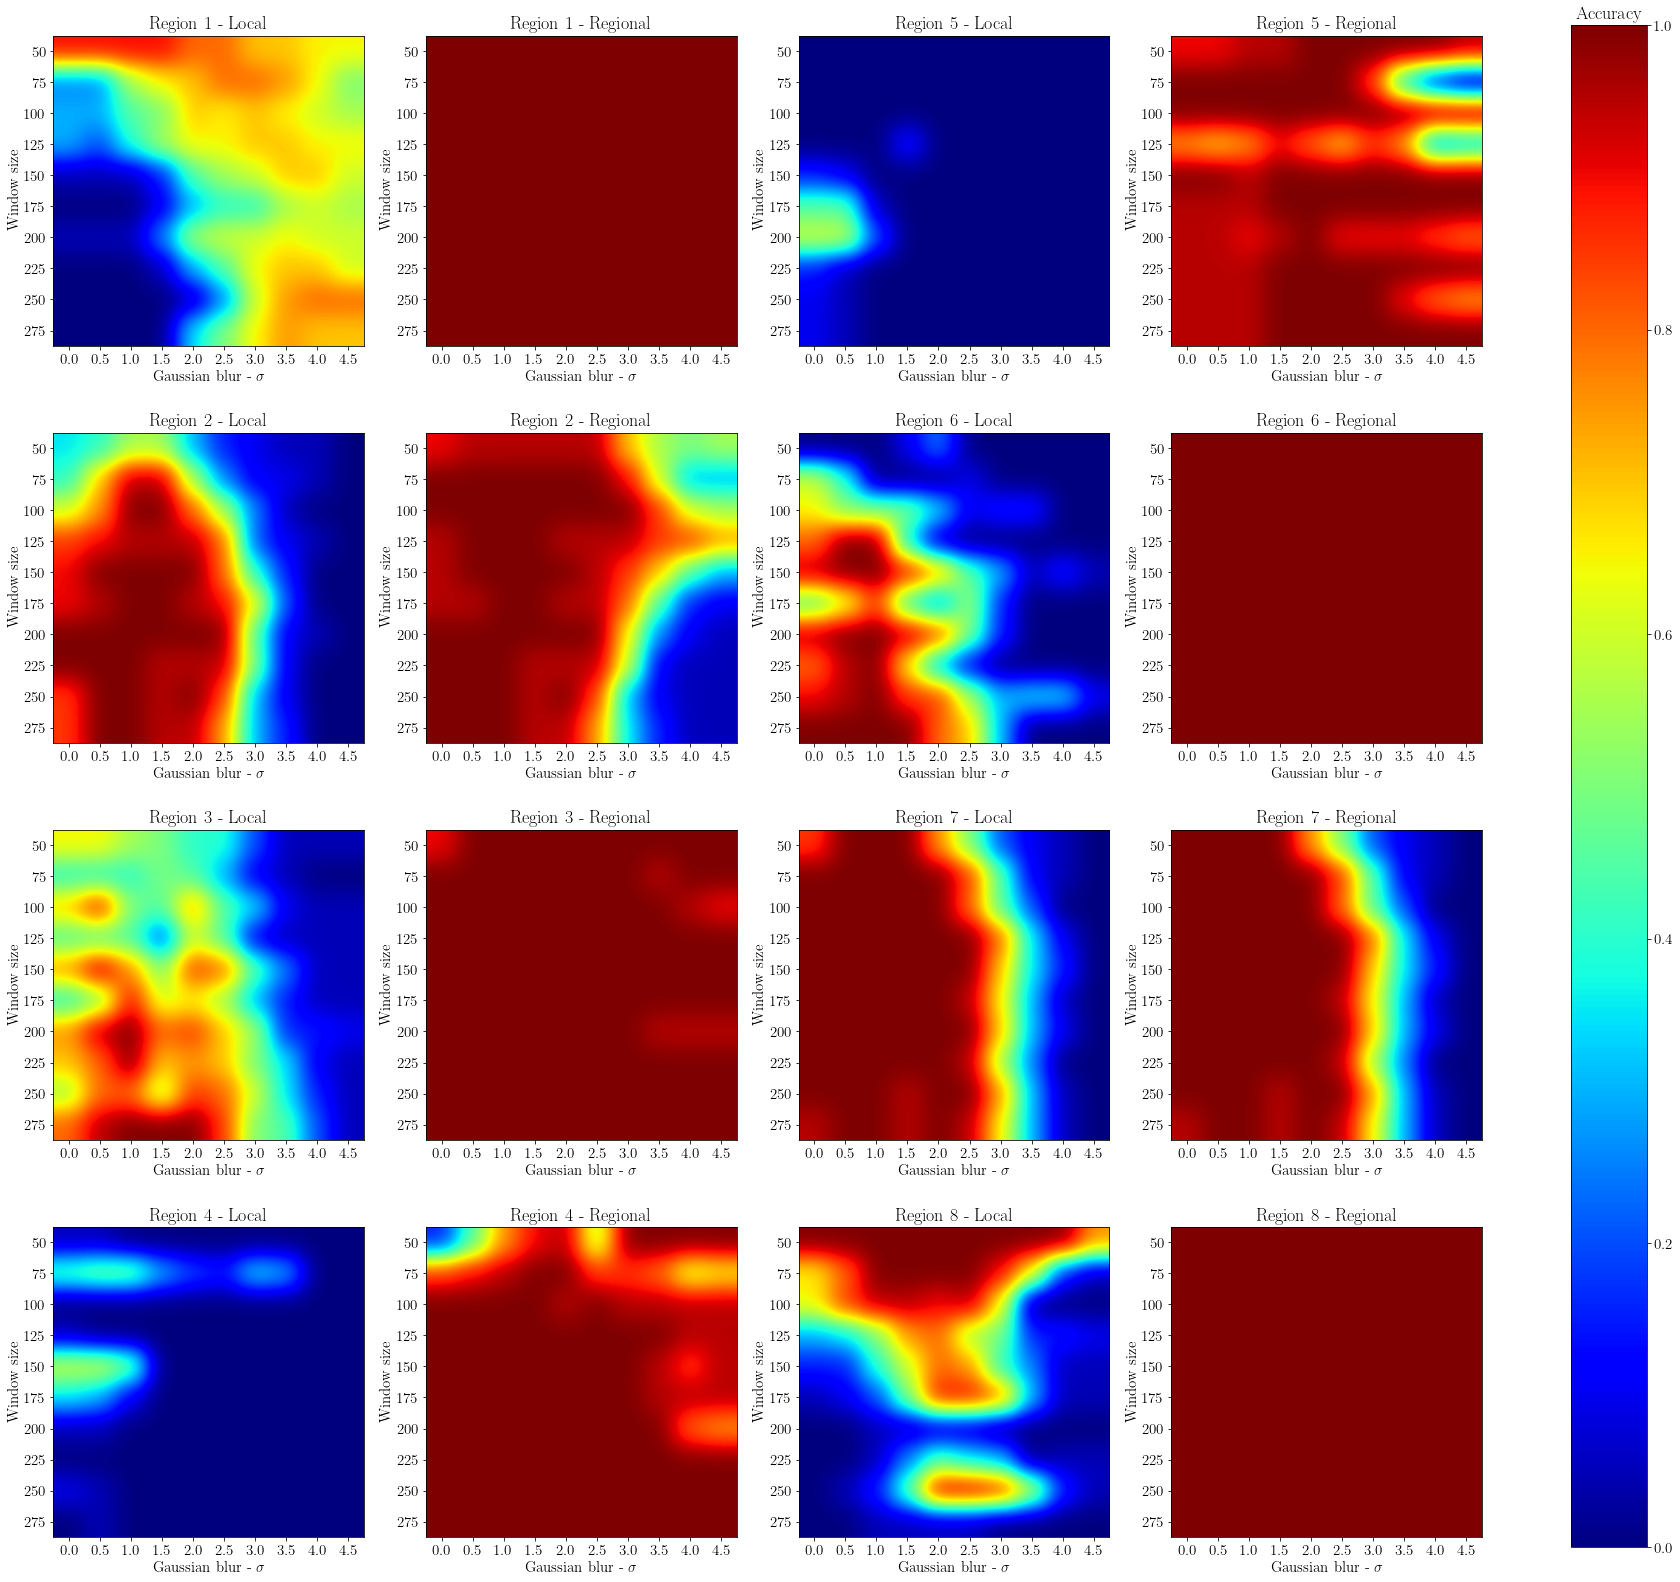

In [80]:
import matplotlib

cmap_str = 'jet'

fig,ax = plt.subplots(4,4,figsize=(32,28))

for i in range(4):
    ax[i,0].set_title('Region %d - Local'%(i+1))
    ax[i,0].imshow(w_gauss_opt_1_list[i],aspect='equal',cmap=cmap_str,interpolation='gaussian',vmin=0,vmax=1)
    ax[i,0].set_xticks(range(10))
    ax[i,0].set_yticks(range(10))
    ax[i,0].set_yticklabels(window_sizes)
    ax[i,0].set_xticklabels(gaussian_std)
    ax[i,0].set_xlabel(r'Gaussian blur - $\sigma$')
    ax[i,0].set_ylabel('Window size')
    #ax[i,0].set_colorbar()
    
    ax[i,1].set_title('Region %d - Regional'%(i+1))
    ax[i,1].imshow(w_gauss_opt_2_list[i],aspect='equal',cmap=cmap_str,interpolation='gaussian',vmin=0,vmax=1)
    ax[i,1].set_xticks(range(10))
    ax[i,1].set_yticks(range(10))
    ax[i,1].set_yticklabels(window_sizes)
    ax[i,1].set_xticklabels(gaussian_std)
    ax[i,1].set_xlabel(r'Gaussian blur - $\sigma$')
    ax[i,1].set_ylabel('Window size')
    #ax[i,1].set_colorbar()
    
    ax[i,2].set_title('Region %d - Local'%(i+1+4))
    ax[i,2].imshow(w_gauss_opt_1_list[i+4],aspect='equal',cmap=cmap_str,interpolation='gaussian',vmin=0,vmax=1)
    ax[i,2].set_xticks(range(10))
    ax[i,2].set_yticks(range(10))
    ax[i,2].set_yticklabels(window_sizes)
    ax[i,2].set_xticklabels(gaussian_std)
    ax[i,2].set_xlabel(r'Gaussian blur - $\sigma$')
    ax[i,2].set_ylabel('Window size')
    #ax[i,0].set_colorbar()
    
    ax[i,3].set_title('Region %d - Regional'%(i+1+4))
    ax[i,3].imshow(w_gauss_opt_2_list[i+4],aspect='equal',cmap=cmap_str,interpolation='gaussian',vmin=0,vmax=1)
    ax[i,3].set_xticks(range(10))
    ax[i,3].set_yticks(range(10))
    ax[i,3].set_yticklabels(window_sizes)
    ax[i,3].set_xticklabels(gaussian_std)
    ax[i,3].set_xlabel(r'Gaussian blur - $\sigma$')
    ax[i,3].set_ylabel('Window size')

clb = plt.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap_str), ax=ax)

clb.ax.set_title('Accuracy');

#plt.savefig('All_regions_local_regional_gridsearch_concept_1.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

## Concept 2

In [82]:
local_specificity = [[1,2],[3,4],[3,4],[5,6],[5,6],[7,8],[7,8],[9,10]]
regional_specificity = [[1,2,3,4],[1,2,3,4],[3,4,5,6],[3,4,5,6],[5,6,7,8],[5,6,7,8],[7,8,9,10],[7,8,9,10]]

#List of accuracy grids per region for local/regional accuracy
B_w_gauss_opt_1_list = []
B_w_gauss_opt_2_list = []

#Parameters
window_sizes = np.arange(10,300,25)

for r in np.arange(1,9):
    region = r
    df = load_test_data(region,2)
    num_sensors = df.shape[1]
    w_gauss_opt_1 = np.zeros(window_sizes.shape[0])
    w_gauss_opt_2 = np.zeros(window_sizes.shape[0])
    

    for window_index,window_param in enumerate(window_sizes):
        sensor_hits = []

        #Loop through the labeled pulse times 
        for i in range(20):

            impact_time = pulse_times_df.iloc[i,region-1]

            data_window_range = [impact_time-window_param,impact_time+window_param]

            #Extract the surrounding time window and apply preprocessing
            data_window = df[data_window_range[0]:data_window_range[1]]#.abs().values
            

            #Instantiate the lead_lag_detector
            max_peaks = max_peak_detector(data_window,num_sensors)

            sensor_hits.append(max_peaks.max_peak_sensor+1)

        accuracy_1 = np.array([i in local_specificity[region-1] for i in sensor_hits]).mean()
        accuracy_2 = np.array([i in regional_specificity[region-1] for i in sensor_hits]).mean()

        w_gauss_opt_1[window_index] = accuracy_1
        w_gauss_opt_2[window_index] = accuracy_2
            
    B_w_gauss_opt_1_list.append(w_gauss_opt_1)
    B_w_gauss_opt_2_list.append(w_gauss_opt_2)

### Figure 4.12

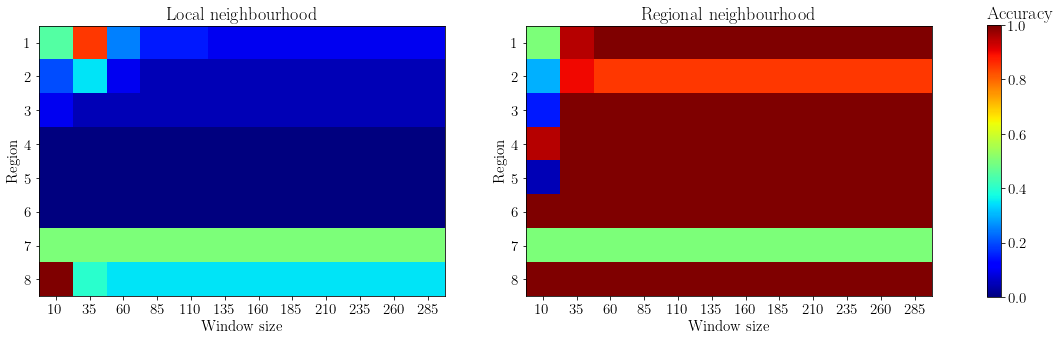

In [95]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].imshow(B_w_gauss_opt_1_list,aspect='equal',cmap='jet',interpolation='none',vmin=0,vmax=1)
ax[0].set_xticks(range(window_sizes.shape[0]));
ax[0].set_xticklabels(window_sizes);
ax[0].set_yticks(np.arange(0,8));
ax[0].set_yticklabels(np.arange(1,9));
ax[0].set_ylabel('Region')
ax[0].set_xlabel('Window size')
ax[0].set_title('Local neighbourhood')

im = ax[1].imshow(B_w_gauss_opt_2_list,aspect='equal',cmap='jet',interpolation='none',vmin=0,vmax=1)
ax[1].set_xticks(range(window_sizes.shape[0]));
ax[1].set_xticklabels(window_sizes);
ax[1].set_yticks(np.arange(0,8));
ax[1].set_yticklabels(np.arange(1,9));
ax[1].set_ylabel('Region')
ax[1].set_xlabel('Window size')
ax[1].set_title('Regional neighbourhood')

cmap_str = 'jet'
clb = plt.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap_str), ax=ax)
clb.ax.set_title('Accuracy',loc='left');

plt.savefig('All_regions_local_regional_gridsearch_concept_2.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

# Algorithm validation

## Detection accuracy

In [14]:
pulse_times_df = pd.read_csv('Experiment_Data/Experiment_pulse_times_Cap_2.csv',index_col=0,sep=';')
pulse_times_df

,region_1_times,region_2_times,region_3_times,region_4_times,region_5_times,region_6_times,region_7_times,region_8_times
0,15400,13815,16368,13660,19696,12454,16366,16159
1,27950,26465,30220,25500,32067,25271,28987,29939
2,40710,38725,42980,38520,45910,38383,42316,42382
3,54180,51425,54718,51050,59323,51005,55269,55721
4,70900,63215,67489,63557,72302,63918,67985,68652
5,89570,74335,80026,75560,86144,76390,80187,80930
6,107600,87435,93563,87866,99146,89206,92524,93912
7,125420,99815,105630,100100,112506,101694,104811,106924
8,142040,112820,118490,112584,126338,114400,117459,119376
9,159390,125165,129935,124864,139583,126970,129847,131933


The algorithm has complete accuracy in identifying time windows in which an impact has occured, with approximate time found to have a mean difference as follows:

In [17]:

time_dif_list = []
for i in np.arange(1,9):
    region_results = pd.read_csv('Experiment_Data/Experiment_analysis_results/Region_%d_classification_results.csv'%i)
    detection_time_dif = abs(pulse_times_df['region_%d_times'%i].values - region_results['approximate_time'].values)
    time_dif_list.append(detection_time_dif.mean())
    

Average time difference between detect impact and true impact time

In [18]:
np.array(time_dif_list).mean()

18.1

In [19]:
(18/9600)

0.001875